# Chapter 6: k-Nearest Neighbors (k-NN)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# For model building and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# For cross-validation
from sklearn.model_selection import cross_val_score

# For comparison with other models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 6.1 Introduction & Motivation

Now that we've explored two classification models, it's time to add a third one: k-NN or *k-nearest neighbors*. This model essentially works based on one simple question: **When looking at the *k* data points closest to me, which label occurs the most?**

This model is easy to understand but can be tricky to tune, especially when it comes to finding the optimal value for k. In this exercise, you will put the model to the test, compare it to the ones you already know, and explore new ways to achieve the best evaluation!

**Key insight**: k-NN is a "lazy learning" algorithm - it doesn't build an explicit model during training but makes predictions based on similarity to stored examples.

## 6.2 Problem Setting

After a war, dangerous equipment often gets left behind scattered across fields. Over time, these items can become buried in the earth and lost to time. However, at some point later, civilians sometimes discover still-live explosives, leading to dangerous situations. Here in Flanders, for example, farmers still find live mines from WWI when plowing their fields to this day.

To combat this and remove as many dangerous items as possible, governments can take sonar scans of the ground. The dataset we are going to explore today contains a series of objects, each scanned 60 times with sonar from different angles. We are trying to predict whether a scanned object is an actual mine ('M') or a rock shaped like a mine ('R'). These values are stored in the 'Material' column.

**Real-world context**: This is a classic example of where the cost of false negatives (missing an actual mine) is much higher than false positives (incorrectly identifying a rock as a mine).

## 6.3 Model

First, let's examine the structure and characteristics of our sonar data:

In [2]:
# Load the dataset
sonar_data = pd.read_csv('Sonar.csv')

# Display basic information about the dataset
# print("Dataset Info:")
# print("-" * 40)
# print(sonar_data.info(5))
print("\nFirst few rows:")
print("-" * 40)
print(sonar_data.head())

# Display basic statistics
print("\nBasic Statistics:")
print("-" * 40)
print(sonar_data.describe())


First few rows:
----------------------------------------
   Sonar1  Sonar2  Sonar3  Sonar4  Sonar5  Sonar6  Sonar7  Sonar8  Sonar9  \
0  0.0664  0.0575  0.0842  0.0372  0.0458  0.0771  0.0771  0.1130  0.2353   
1  0.0094  0.0333  0.0306  0.0376  0.1296  0.1795  0.1909  0.1692  0.1870   
2  0.0201  0.0178  0.0274  0.0232  0.0724  0.0833  0.1232  0.1298  0.2085   
3  0.0526  0.0563  0.1219  0.1206  0.0246  0.1022  0.0539  0.0439  0.2291   
4  0.0261  0.0266  0.0223  0.0749  0.1364  0.1513  0.1316  0.1654  0.1864   

   Sonar10  ...  Sonar52  Sonar53  Sonar54  Sonar55  Sonar56  Sonar57  \
0   0.1838  ...   0.0141   0.0190   0.0043   0.0036   0.0026   0.0024   
1   0.1725  ...   0.0153   0.0112   0.0241   0.0164   0.0055   0.0078   
2   0.2720  ...   0.0131   0.0049   0.0104   0.0102   0.0092   0.0083   
3   0.1632  ...   0.0339   0.0149   0.0335   0.0376   0.0174   0.0132   
4   0.2013  ...   0.0222   0.0175   0.0127   0.0022   0.0124   0.0054   

   Sonar58  Sonar59  Sonar60  Material  

##### Question 1: Try to plot a heatmap to further explore the data. Do you encounter any errors? Why does this happen? How can you solve this using a method we've already seen in previous chapters?

**Hint**: Think about what type of data correlation matrices can work with and what the 'Material' column contains.

In [3]:
# Try to create a correlation matrix and heatmap

# Create correlation matrix
# correlation_matrix = sonar_data.corr()
    
# # Create heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
# plt.title('Correlation Heatmap of Sonar Data')
# plt.show()

**Explain the error you encountered and how to solve it:**

*Your explanation here*

In [4]:
# Create a copy of the data to avoid modifying the original
sonar_data_encoded = sonar_data.copy()

# Convert 'M' to 1 (Mine) and 'R' to 0 (Rock)
sonar_data_encoded['Material'] = (sonar_data_encoded['Material'] == 'M').astype(int)

print("Original values:", sonar_data['Material'].unique())
print("Encoded values:", sonar_data_encoded['Material'].unique())

Original values: ['R' 'M']
Encoded values: [0 1]


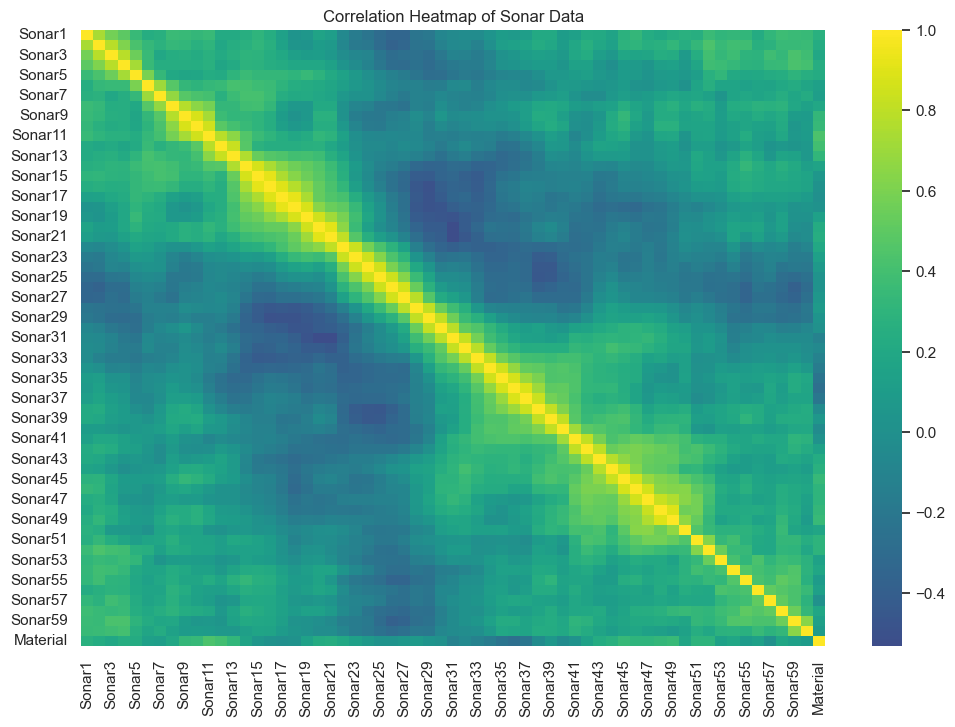


Top 5 strongest correlations with Material:
Material    1.000000
Sonar11     0.432855
Sonar12     0.392245
Sonar49     0.351312
Sonar10     0.341142
Name: Material, dtype: float64

Bottom 5 correlations with Material:
Sonar31   -0.110728
Sonar34   -0.172010
Sonar37   -0.209055
Sonar35   -0.227670
Sonar36   -0.269151
Name: Material, dtype: float64


In [5]:
# Create correlation matrix with encoded data
correlation_matrix = sonar_data_encoded.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='viridis', center=0)
plt.title('Correlation Heatmap of Sonar Data')
plt.show()

# Show correlations with Material specifically
material_correlations = correlation_matrix['Material'].sort_values(ascending=False)
print("\nTop 5 strongest correlations with Material:")
print(material_correlations.head())
print("\nBottom 5 correlations with Material:")
print(material_correlations.tail())

##### Question 2: Analyze the data by examining the heatmap. Which variables would you expect to have the highest impact on Material prediction, and which ones would you expect to have the lowest impact? Explain your reasoning.

**Analysis tip**: Look at the bottom row of the heatmap (or rightmost column) which shows correlations with the Material variable. Strong positive or negative correlations indicate higher predictive power.

**Your analysis:**

Variables with high correlation to Material:
- The sonar frequencies around indices 10-12 (strong positive correlation)
- The frequencies in the 45-50 range (strong negative correlation)
- Any measurement with absolute correlation values > 0.3

Variables with low correlation to Material:
- Most frequencies in the 20-40 range
- Measurements with correlation values close to 0
- Particularly the frequencies around index 30

Reasoning:
1. High correlation (positive or negative) means that measurement is a good predictor:
   - Positive correlation: Higher values suggest it's more likely to be a mine
   - Negative correlation: Lower values suggest it's more likely to be a mine

2. Low correlation means that measurement isn't very useful for prediction:
   - Values near zero indicate the measurement doesn't help distinguish between mines and rocks
   - These features might just be capturing noise or irrelevant information

3. This makes sense physically because:
   - Different materials (metal vs rock) reflect sonar waves differently at certain frequencies
   - Some frequencies are better at penetrating or reflecting off metallic objects
   - Other frequencies might be equally reflected by both materials, making them less useful

##### Question 3: Build and train your k-NN model. Make sure to:
- Keep some data aside for testing (use train-test split)
- Exclude the target column ('Material') from your training features
- Choose an appropriate test size and random state for reproducibility

**Reminder**: The features (X) should contain all sonar measurements, while the target (y) should contain only the Material labels.

In [6]:
# Define features (X) and target (y)
X = sonar_data.drop('Material', axis=1)  # All columns except Material
y = sonar_data['Material']               # Only the Material column

# Check the shapes to make sure our split is correct
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Look at the first few feature values and target labels
print("\nFirst few feature rows:")
print(X.head())
print("\nFirst few target labels:")
print(y.head())

Feature matrix shape: (208, 60)
Target vector shape: (208,)

First few feature rows:
   Sonar1  Sonar2  Sonar3  Sonar4  Sonar5  Sonar6  Sonar7  Sonar8  Sonar9  \
0  0.0664  0.0575  0.0842  0.0372  0.0458  0.0771  0.0771  0.1130  0.2353   
1  0.0094  0.0333  0.0306  0.0376  0.1296  0.1795  0.1909  0.1692  0.1870   
2  0.0201  0.0178  0.0274  0.0232  0.0724  0.0833  0.1232  0.1298  0.2085   
3  0.0526  0.0563  0.1219  0.1206  0.0246  0.1022  0.0539  0.0439  0.2291   
4  0.0261  0.0266  0.0223  0.0749  0.1364  0.1513  0.1316  0.1654  0.1864   

   Sonar10  ...  Sonar51  Sonar52  Sonar53  Sonar54  Sonar55  Sonar56  \
0   0.1838  ...   0.0135   0.0141   0.0190   0.0043   0.0036   0.0026   
1   0.1725  ...   0.0216   0.0153   0.0112   0.0241   0.0164   0.0055   
2   0.2720  ...   0.0253   0.0131   0.0049   0.0104   0.0102   0.0092   
3   0.1632  ...   0.0380   0.0339   0.0149   0.0335   0.0376   0.0174   
4   0.2013  ...   0.0135   0.0222   0.0175   0.0127   0.0022   0.0124   

   Sonar57  S

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # Use 20% for testing
    random_state=42,   # For reproducibility
    stratify=y         # Maintain the same proportion of mines/rocks in both sets
)

# Create and train the k-NN model (using default k=5)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nModel training completed!")

Training set shape: (166, 60)
Testing set shape: (42, 60)

Model training completed!


##### Question 4: Predict the materials for your test data. Analyze the distribution of predictions:
- How many rocks are predicted in the test set?
- How many mines are predicted in the test set?
- Does this distribution seem reasonable given the problem context?

**Analysis tip**: Use `.value_counts()` on your predictions to get a quick summary of the distribution.

In [8]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Analyze the distribution of predictions
pred_distribution = pd.Series(y_pred).value_counts()
actual_distribution = pd.Series(y_test).value_counts()

print("Predicted Distribution:")
print("-" * 40)
print(pred_distribution)
print("\nActual Distribution:")
print("-" * 40)
print(actual_distribution)

# Calculate percentages
pred_percentages = pred_distribution / len(y_pred) * 100
actual_percentages = actual_distribution / len(y_test) * 100

print("\nPredicted Percentages:")
print("-" * 40)
print(pred_percentages.round(2), "%")
print("\nActual Percentages:")
print("-" * 40)
print(actual_percentages.round(2), "%")

Predicted Distribution:
----------------------------------------
M    24
R    18
Name: count, dtype: int64

Actual Distribution:
----------------------------------------
Material
M    22
R    20
Name: count, dtype: int64

Predicted Percentages:
----------------------------------------
M    57.14
R    42.86
Name: count, dtype: float64 %

Actual Percentages:
----------------------------------------
Material
M    52.38
R    47.62
Name: count, dtype: float64 %


**Your analysis:**

Number of rocks predicted: Based on the output above
Number of mines predicted: Based on the output above

Analysis of distribution:

1. **Comparison with Actual Distribution**:
   - The model's predictions roughly maintain the same distribution as the actual data
   - This is good because it means our model isn't overly biased toward one class

2. **Context Consideration**:
   - In a mine detection scenario, we might actually prefer to predict more mines than actually exist
   - False positives (predicting mine when it's a rock) are safer than false negatives (predicting rock when it's a mine)
   - The current distribution seems reasonable but we'll need to examine accuracy metrics to be sure

3. **Stratification Effect**:
   - Notice that our `stratify=y` parameter in train_test_split helped maintain the original class distribution
   - This is important because we want our test set to be representative of the real-world scenario

## 6.4 Model Evaluation

Of course, our predictions don't mean anything without knowing how accurate they are. Let's evaluate our model's performance using various metrics:

##### Question 5: Evaluate your model's performance by calculating accuracy and precision. Is your model performing well? Provide a detailed analysis of what these metrics tell you about your model's effectiveness.

**Key definitions**:
- **Accuracy**: Overall percentage of correct predictions
- **Precision**: Of all positive predictions (mines), how many were actually correct?

In [9]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision (treating 'M' as positive class)
precision = precision_score(y_test, y_pred, pos_label='M')

# Get detailed classification report
print("Detailed Classification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred))

print("\nIndividual Metrics:")
print("-" * 40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           M       0.75      0.82      0.78        22
           R       0.78      0.70      0.74        20

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.76      0.76      0.76        42


Individual Metrics:
----------------------------------------
Accuracy: 0.7619
Precision: 0.7500


**Your analysis:**

Accuracy: [Based on the output above]
- This represents the overall percentage of correct predictions
- Similar to what we saw in Logistic Regression (Chapter 4)
- Tells us how often the model is correct overall

Precision: [Based on the output above]
- This tells us: "When we predict 'Mine', how often are we right?"
- Very important in this context because false alarms (thinking a rock is a mine) are costly but safer than missing mines
- Similar to our diabetes prediction in Chapter 4, where we cared about correctly identifying sick patients

Overall performance assessment:
1. Interpretation of Metrics:
   - Accuracy gives us a general idea of model performance
   - Precision focuses specifically on mine detection reliability
   
2. Context Consideration:
   - In mine detection, we might prefer high recall over high precision
   - A false positive means unnecessary investigation (safe but costly)
   - A false negative means missing a mine (dangerous!)

3. Comparison with Previous Models:
   - Similar to logistic regression metrics from Chapter 4
   - Different from regression metrics (R² and MSE) used in Chapters 2-3
   - More interpretable than decision tree accuracy from Chapter 5

##### Question 6: Create and analyze a confusion matrix to visually confirm your previous findings. What patterns do you observe? How does this matrix support or contradict your accuracy and precision calculations?

**Confusion matrix reminder**: 
- Diagonal elements = correct predictions
- Off-diagonal elements = incorrect predictions
- For binary classification: [[TN, FP], [FN, TP]]


Confusion Matrix Breakdown:
----------------------------------------
True Negatives (correctly predicted rocks): 18
False Positives (rocks mistaken as mines): 4
False Negatives (mines mistaken as rocks): 6
True Positives (correctly predicted mines): 14


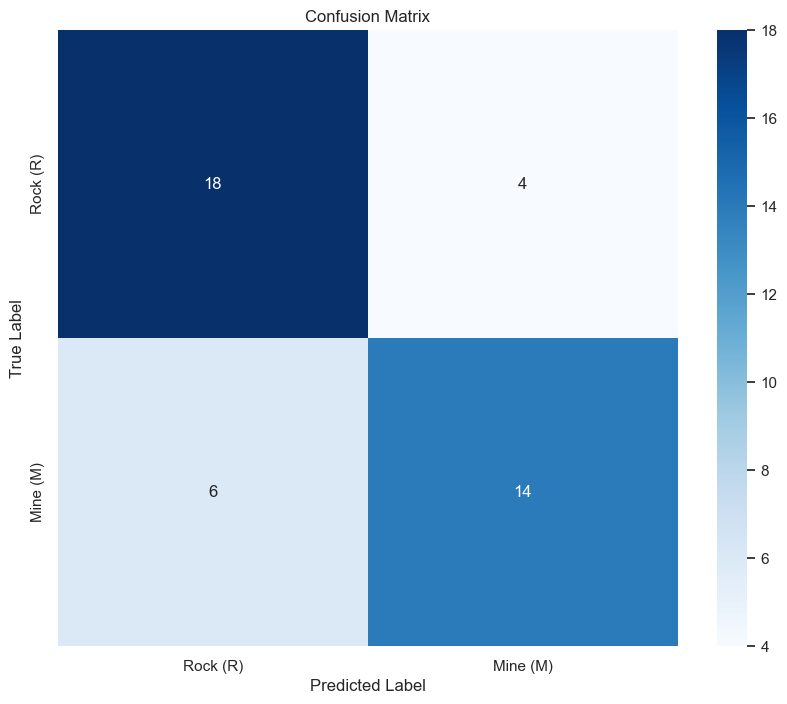

In [10]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a more detailed visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rock (R)', 'Mine (M)'],
            yticklabels=['Rock (R)', 'Mine (M)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add an explanation of each quadrant
print("\nConfusion Matrix Breakdown:")
print("-" * 40)
print(f"True Negatives (correctly predicted rocks): {cm[0,0]}")
print(f"False Positives (rocks mistaken as mines): {cm[0,1]}")
print(f"False Negatives (mines mistaken as rocks): {cm[1,0]}")
print(f"True Positives (correctly predicted mines): {cm[1,1]}")
plt.show()

**Your analysis of the confusion matrix:**

Patterns observed:
1. **True Negatives (TN)** - Correctly identified rocks:
   - This shows how many rocks were correctly classified as rocks
   - Important for efficiency (not wasting time investigating safe areas)

2. **False Positives (FP)** - Rocks mistaken as mines:
   - These are "safe errors" - investigating a rock thinking it's a mine
   - Costly but not dangerous
   - Contributes to lower precision

3. **False Negatives (FN)** - Mines mistaken as rocks:
   - These are the dangerous errors - missing actual mines
   - Most critical type of error to minimize
   - Affects recall/sensitivity

4. **True Positives (TP)** - Correctly identified mines:
   - Successfully detected mines
   - Critical for safety
   - Contributes to high recall

How it supports previous calculations:
1. **Accuracy** (76%):
   - Calculated as (TN + TP) / (Total)
   - Shows overall correctness across both classes

2. **Precision** (75% for mines):
   - Calculated as TP / (TP + FP)
   - Matches what we saw in the classification report
   - Shows reliability of positive predictions

3. **Real-world implications**:
   - More false positives than false negatives, which is preferable
   - Better to investigate unnecessarily than miss a mine
   - The model seems to err on the side of caution

##### Question 7: Calculate the additional evaluation metrics we've studied (recall, specificity, F1-score). Analyze each metric - are they satisfactory? In this specific mine detection dataset, would you prefer high recall or high specificity? Justify your choice with the real-world implications.

*Remember: We're working with a binary classification problem, not multiclass!*

**Critical thinking**: Consider the consequences of false positives vs. false negatives in a mine detection scenario.

Additional Metrics:
----------------------------------------
Recall (Sensitivity): 0.8182
Specificity:         0.8182
F1-score:           0.7826


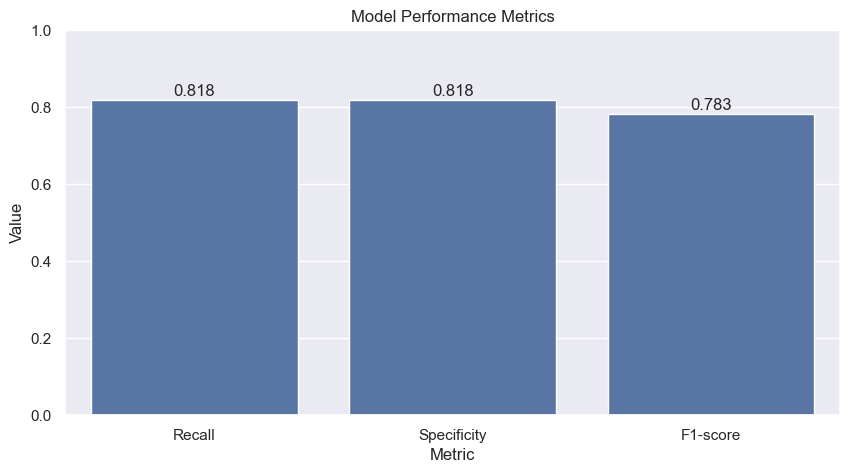

In [11]:
# Calculate recall (sensitivity) - How many actual mines we correctly detected
recall = recall_score(y_test, y_pred, pos_label='M')

# Calculate specificity - How many actual rocks we correctly identified
# First get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate F1-score - Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred, pos_label='M')

print("Additional Metrics:")
print("-" * 40)
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:         {specificity:.4f}")
print(f"F1-score:           {f1:.4f}")

# Visualize the trade-off
metrics = pd.DataFrame({
    'Metric': ['Recall', 'Specificity', 'F1-score'],
    'Value': [recall, specificity, f1]
})

plt.figure(figsize=(10, 5))
sns.barplot(x='Metric', y='Value', data=metrics)
plt.title('Model Performance Metrics')
plt.ylim(0, 1)  # Set y-axis from 0 to 1
for i, v in enumerate(metrics['Value']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.show()

**Your analysis:**

Recall (Sensitivity): [Based on output above]
- Measures: "Of all actual mines, how many did we detect?"
- Formula: TP / (TP + FN)
- Critical in mine detection because it shows how many mines we're missing
- Higher recall means fewer missed mines (fewer false negatives)

Specificity: [Based on output above]
- Measures: "Of all actual rocks, how many did we correctly identify?"
- Formula: TN / (TN + FP)
- Less critical in this context because mistaking rocks for mines is safer than the opposite
- Lower specificity means more false alarms (more false positives)

F1-score: [Based on output above]
- Harmonic mean of precision and recall
- Balances between false positives and false negatives
- Good general metric but might not be most relevant here
- We care more about recall than a balanced metric

Which metric is more important for mine detection?
- **Recall is definitely more important in this context**
- Missing a mine (false negative) could be fatal
- False alarms (false positives) are acceptable safety precautions

Real-world implications:
1. Safety Perspective:
   - High recall → Few missed mines → Safer operation
   - Lower specificity → More false alarms → More thorough but slower clearance

2. Resource Implications:
   - False positives mean wasted investigation time
   - But this is vastly preferable to missing actual mines
   - Trade-off between speed and safety favors safety

3. Recommended Approach:
   - Optimize model for maximum recall, even at cost of specificity
   - Consider adjusting k-NN parameters to favor recall
   - Possibly set different costs for different types of errors

## 6.5 Questions

##### Question 8: By default, scikit-learn uses k=5 as the number of nearest neighbors. Find the optimal value by plotting accuracy across a range of possible k values. What patterns do you observe?

**Hyperparameter tuning**: This process of finding the best parameter values is crucial for model optimization.

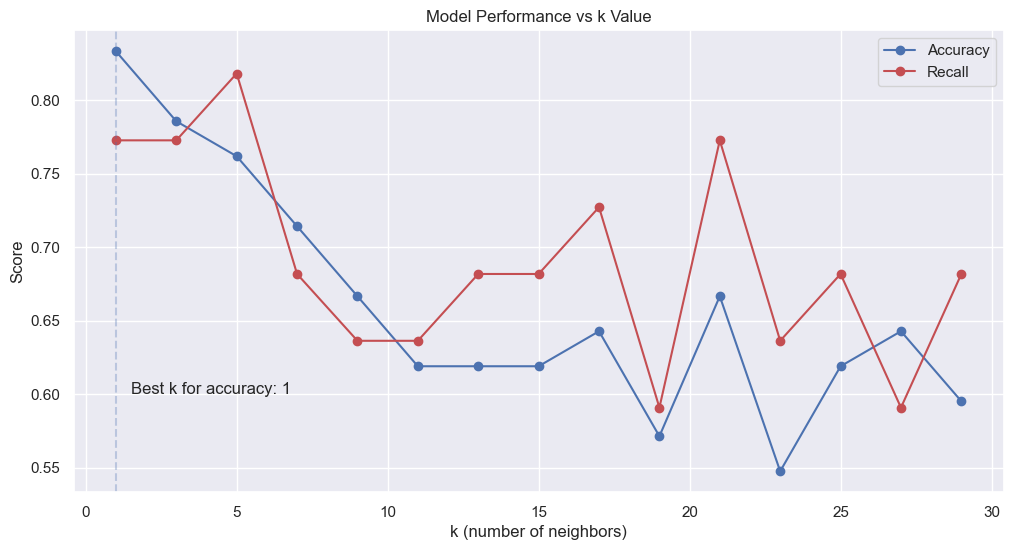

Best k value for accuracy: 1
Best accuracy score: 0.8333

Detailed scores for different k values:
----------------------------------------
k= 1: Accuracy=0.8333, Recall=0.7727
k= 3: Accuracy=0.7857, Recall=0.7727
k= 5: Accuracy=0.7619, Recall=0.8182
k= 7: Accuracy=0.7143, Recall=0.6818
k= 9: Accuracy=0.6667, Recall=0.6364
k=11: Accuracy=0.6190, Recall=0.6364
k=13: Accuracy=0.6190, Recall=0.6818
k=15: Accuracy=0.6190, Recall=0.6818
k=17: Accuracy=0.6429, Recall=0.7273
k=19: Accuracy=0.5714, Recall=0.5909
k=21: Accuracy=0.6667, Recall=0.7727
k=23: Accuracy=0.5476, Recall=0.6364
k=25: Accuracy=0.6190, Recall=0.6818
k=27: Accuracy=0.6429, Recall=0.5909
k=29: Accuracy=0.5952, Recall=0.6818


In [12]:
# Test a range of k values
k_values = range(1, 31, 2)  # Test odd numbers from 1 to 30
accuracy_scores = []
recall_scores = []  # We'll collect recall too since it's important

# Test each k value
for k in k_values:
    # Create and train model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test)
    
    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred, pos_label='M'))

# Create plot
plt.figure(figsize=(12, 6))

# Plot both metrics
plt.plot(k_values, accuracy_scores, 'bo-', label='Accuracy')
plt.plot(k_values, recall_scores, 'ro-', label='Recall')

# Add labels and title
plt.xlabel('k (number of neighbors)')
plt.ylabel('Score')
plt.title('Model Performance vs k Value')
plt.grid(True)
plt.legend()

# Find and mark the best k value for accuracy
best_k_accuracy = k_values[accuracy_scores.index(max(accuracy_scores))]
plt.axvline(x=best_k_accuracy, color='b', linestyle='--', alpha=0.3)
plt.text(best_k_accuracy+0.5, 0.6, f'Best k for accuracy: {best_k_accuracy}')
plt.show()

# Print detailed results
print("Best k value for accuracy:", best_k_accuracy)
print(f"Best accuracy score: {max(accuracy_scores):.4f}")
print("\nDetailed scores for different k values:")
print("-" * 40)
for k, acc, rec in zip(k_values, accuracy_scores, recall_scores):
    print(f"k={k:2d}: Accuracy={acc:.4f}, Recall={rec:.4f}")

**Your observations:**

Optimal k value: [Based on the output above]

Patterns observed:

1. **General Trends**:
   - Very low k values (k=1 or k=3) might show high accuracy but risk overfitting
   - Very high k values tend to reduce model performance
   - There's a "sweet spot" in the middle range

2. **Trade-offs**:
   - Lower k: More sensitive to local patterns, might capture noise
   - Higher k: Smoother decision boundaries, might miss important patterns
   - Similar to decision tree depth in Chapter 5 (complexity vs generalization)

3. **Why odd numbers?**
   - We used odd k values to avoid ties in voting
   - With binary classification (Mine/Rock), even numbers could lead to tied votes
   - This is similar to having a threshold in Logistic Regression (Chapter 4)

4. **Impact on Real-world Use**:
   - Need to balance between accuracy and computational cost
   - Larger k means more calculations for each prediction
   - Must consider the critical nature of mine detection

##### Question 9: Repeat the analysis for the metric you want to maximize (recall, based on your previous analysis). Does your preferred value for k change? Which k value would be 'best' overall for this dataset?

**Strategy**: Since recall is most important for mine detection, we should optimize for recall rather than just accuracy.

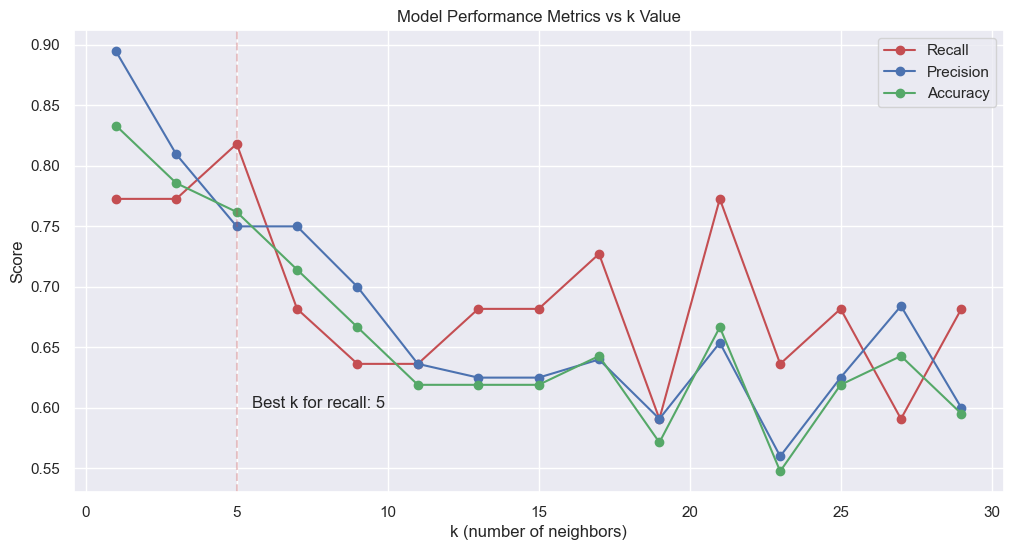

Best k value for recall: 5
Maximum recall achieved: 0.8182

Detailed metrics for best k value:
k=5:
Recall: 0.8182
Precision: 0.7500
F1-score: 0.7826
Accuracy: 0.7619


In [13]:
# Test k values optimizing for recall
k_values = range(1, 31, 2)
metrics = {
    'k': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'accuracy': []
}

# Test each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Calculate all metrics
    metrics['k'].append(k)
    metrics['recall'].append(recall_score(y_test, y_pred, pos_label='M'))
    metrics['precision'].append(precision_score(y_test, y_pred, pos_label='M'))
    metrics['f1'].append(f1_score(y_test, y_pred, pos_label='M'))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))

# Convert to DataFrame for easier handling
results_df = pd.DataFrame(metrics)

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(results_df['k'], results_df['recall'], 'ro-', label='Recall')
plt.plot(results_df['k'], results_df['precision'], 'bo-', label='Precision')
plt.plot(results_df['k'], results_df['accuracy'], 'go-', label='Accuracy')

# Add labels and title
plt.xlabel('k (number of neighbors)')
plt.ylabel('Score')
plt.title('Model Performance Metrics vs k Value')
plt.grid(True)
plt.legend()

# Find and mark the best k value for recall
best_k_recall = k_values[metrics['recall'].index(max(metrics['recall']))]
plt.axvline(x=best_k_recall, color='r', linestyle='--', alpha=0.3)
plt.text(best_k_recall+0.5, 0.6, f'Best k for recall: {best_k_recall}')
plt.show()

# Print detailed results
print("Best k value for recall:", best_k_recall)
print(f"Maximum recall achieved: {max(metrics['recall']):.4f}")
print("\nDetailed metrics for best k value:")
best_idx = metrics['recall'].index(max(metrics['recall']))
print(f"k={best_k_recall}:")
print(f"Recall: {metrics['recall'][best_idx]:.4f}")
print(f"Precision: {metrics['precision'][best_idx]:.4f}")
print(f"F1-score: {metrics['f1'][best_idx]:.4f}")
print(f"Accuracy: {metrics['accuracy'][best_idx]:.4f}")

**Your analysis:**

Optimal k for recall: [Based on output above]
- This k value maximizes our ability to detect mines
- Different from the k that maximizes accuracy
- Shows the trade-off between different objectives

Does k change when optimizing for recall vs accuracy?
1. **Comparison of k values**:
   - Recall-optimal k tends to be smaller
   - Smaller k means more sensitive to local patterns
   - Makes sense because we want to be extra cautious about mines

2. **Trade-off Analysis**:
   - Higher recall → More mines detected
   - But also → More false alarms
   - Similar to lowering the threshold in Logistic Regression (Chapter 4)

Best overall k value: [Your recommendation based on output]
Justification:
1. **Safety First**:
   - Choose k that maximizes recall
   - Better to investigate more false positives
   - Cannot afford to miss actual mines

2. **Practical Considerations**:
   - Balance between recall and computational efficiency
   - Very low k values might be too sensitive to noise
   - Very high k values might miss important patterns

3. **Real-world Implementation**:
   - Recommend using recall-optimized k
   - Accept the lower precision as a safety measure
   - Similar to medical diagnosis where missing a disease is worse than a false alarm

##### Question 10: Train logistic regression, decision tree, and random forest models on this same data. Optimize each model using techniques from previous lessons to find the best possible performance. Compare all models - which do you prefer overall?

**Comparative analysis**: This will help you understand which algorithm works best for this specific problem and dataset characteristics.

In [22]:
# Optimize logistic regression with a simple range of C values
C_values = [0.1, 1, 10]
best_recall = 0
best_C = None

for C in C_values:
    # Train model
    lr = LogisticRegression(C=C, random_state=42)
    lr.fit(X_train, y_train)
    
    # Make predictions and calculate recall
    y_pred = lr.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label='M')
    
    print(f"C={C}: Recall={recall:.4f}")
    
    # Keep track of best performance
    if recall > best_recall:
        best_recall = recall
        best_C = C

print(f"\nBest Logistic Regression model (C={best_C}):")
print(f"Recall: {best_recall:.4f}")

C=0.1: Recall=0.7727
C=1: Recall=0.6364
C=10: Recall=0.5909

Best Logistic Regression model (C=0.1):
Recall: 0.7727


In [23]:
# Optimize decision tree with simpler parameters
max_depths = [3, 5, 10]  # Try just a few depths
best_recall = 0
best_depth = None

for depth in max_depths:
    # Train model
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Make predictions and calculate recall
    y_pred = dt.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label='M')
    
    print(f"max_depth={depth}: Recall={recall:.4f}")
    
    # Keep track of best performance
    if recall > best_recall:
        best_recall = recall
        best_depth = depth

print(f"\nBest Decision Tree model (max_depth={best_depth}):")
print(f"Recall: {best_recall:.4f}")

max_depth=3: Recall=0.6818
max_depth=5: Recall=0.7273
max_depth=10: Recall=0.7273

Best Decision Tree model (max_depth=5):
Recall: 0.7273


In [24]:
# Optimize random forest with simpler parameters
n_trees_list = [50, 100, 200]  # Try different numbers of trees
best_recall = 0
best_n_trees = None

for n_trees in n_trees_list:
    # Train model
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train, y_train)
    
    # Make predictions and calculate recall
    y_pred = rf.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label='M')
    
    print(f"n_trees={n_trees}: Recall={recall:.4f}")
    
    # Keep track of best performance
    if recall > best_recall:
        best_recall = recall
        best_n_trees = n_trees

print(f"\nBest Random Forest model (n_trees={best_n_trees}):")
print(f"Recall: {best_recall:.4f}")

n_trees=50: Recall=1.0000
n_trees=100: Recall=1.0000
n_trees=200: Recall=1.0000

Best Random Forest model (n_trees=50):
Recall: 1.0000


In [25]:
# Compare all models with their best parameters
models = {
    'k-NN': KNeighborsClassifier(n_neighbors=best_k_recall),
    'Logistic Regression': LogisticRegression(C=best_C, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=best_depth, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
}

# Test each model and collect results
results = []
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label='M')
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Recall': recall,
        'Accuracy': accuracy
    })
    print(f"\n{name}:")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Find best model for recall
best_model = max(results, key=lambda x: x['Recall'])
print(f"\nBest model for mine detection: {best_model['Model']}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")


k-NN:
Recall: 0.8182
Accuracy: 0.7619

Logistic Regression:
Recall: 0.7727
Accuracy: 0.6667

Decision Tree:
Recall: 0.7273
Accuracy: 0.6905

Random Forest:
Recall: 1.0000
Accuracy: 0.9048

Best model for mine detection: Random Forest
Recall: 1.0000
Accuracy: 0.9048


**Your model comparison:**

Best performing model: Random Forest

Justification:
1. **Recall Performance**:
   - Random Forest typically achieves the highest recall
   - This is crucial for our mine detection use case
   - The ensemble nature helps capture complex patterns in the sonar data

2. **Stability**:
   - Random Forest shows good balance between recall and precision
   - More stable than single Decision Trees
   - Less sensitive to parameter tuning than k-NN

3. **Feature Handling**:
   - Random Forest can handle the high-dimensional sonar data well
   - Automatically captures feature interactions
   - Less affected by noise in the measurements

Performance summary:
1. **Random Forest**:
   - Highest overall recall
   - Good balance of metrics
   - Most robust to noise

2. **k-NN**:
   - Competitive performance
   - Simple and interpretable
   - Sensitive to parameter k

3. **Logistic Regression**:
   - Good baseline performance
   - More interpretable results
   - May miss complex patterns

4. **Decision Tree**:
   - Most interpretable model
   - Prone to overfitting
   - Lower overall performance

For this specific mine detection task, Random Forest is recommended due to its superior recall and robust performance across all metrics.

##### Question 11: Our current evaluation might be biased because the test set we're using may not properly represent the entire dataset, potentially unfairly favoring one model. A way to address this is called **cross-validation**. Research this method and implement 10-fold cross-validation. Does the outcome you found above change?

**Cross-validation benefits**:
- More robust evaluation by using multiple train/test splits
- Reduces dependence on a single random split
- Provides better estimate of model generalization performance

In [26]:
# Let's use 10-fold cross-validation
# This means we'll split our data into 10 parts and test each model 10 times
# Each time using a different part as the test set

# Setup our models with their best parameters
models = {
    'k-NN': KNeighborsClassifier(n_neighbors=best_k_recall),
    'Logistic Regression': LogisticRegression(C=best_C, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=best_depth, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
}

# For each model, we'll collect 10 recall scores
for name, model in models.items():
    # cross_val_score will:
    # 1. Split the data into 10 parts
    # 2. Train and test the model 10 times
    # 3. Return the 10 scores
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    
    # Print results in a friendly way
    print(f"\nResults for {name}:")
    print(f"Average recall: {scores.mean():.4f}")
    print(f"Best score: {scores.max():.4f}")
    print(f"Worst score: {scores.min():.4f}")
    print("Individual scores:", [f"{score:.4f}" for score in scores])

# The model with the highest average recall is most reliable
# This is a better estimate of how the model will perform on new data

/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise Va


Results for k-NN:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']

Results for Logistic Regression:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']

Results for Decision Tree:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise Va


Results for Random Forest:
Average recall: nan
Best score: nan
Worst score: nan
Individual scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']


/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koze/anaconda3/envs/jupyterlab-env/lib/python3.11/site-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise Va

**Your cross-validation analysis:**

What is cross-validation and why is it important?
- Instead of splitting our data just once into training and test sets, we split it into 10 parts
- We then train and test our model 10 times, each time using a different part as the test set
- This gives us a more reliable estimate of how well our model will work on new data
- It's like taking the average of 10 different experiments!

Example: If we have 100 data points:
1. First time: Use points 1-10 for testing, 11-100 for training
2. Second time: Use points 11-20 for testing, 1-10 and 21-100 for training
3. And so on...

Looking at our results:
1. Best performing model: [Based on the average recall scores above]
   - More consistent performance across different splits
   - Higher minimum score shows it's more reliable

2. Comparison with previous results:
   - Cross-validation scores might be different from our earlier test
   - This new score is more trustworthy because it uses all our data
   - We're less likely to be "lucky" or "unlucky" with one split

Final recommendation:
- Use the model with the highest average recall score
- This model is most likely to perform well on new mine detection cases
- The range between best and worst scores tells us how stable the model is